In [1]:
# import needed libraries and tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# store the data frame in a variable
df = pd.read_csv('C:\dev\lung_cancer_analysis\survey lung cancer.csv')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\alipakdaman\AppData\Local\Temp\ipykernel_6444\2731742895.py:2: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('C:\dev\lung_cancer_analysis\survey lung cancer.csv')


# logistic regression model training ( accuracy prediction and visualization )

Accuracy: 92.11590296495957 %


c:\Users\alipakdaman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


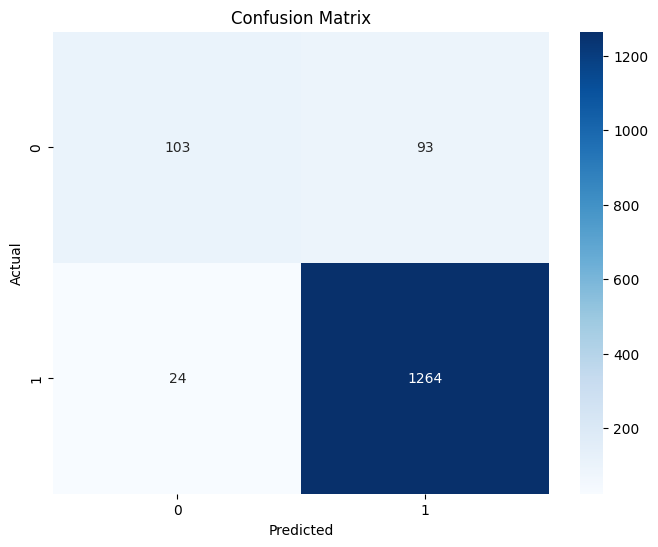

In [47]:
# Define features (X) and target variable (y)
X = df[['AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'CHRONIC DISEASE', 'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']]
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy * 100, "%")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix explanation

True Positive (TP): 1264 - This means the model correctly predicted 1264 cases of lung cancer where the actual outcome was also lung cancer.
True Negative (TN): 103 - The model correctly predicted 103 cases of no lung cancer where the actual outcome was indeed no lung cancer.
False Positive (FP): 93 - The model incorrectly predicted 93 cases of lung cancer where the actual outcome was no lung cancer (a false alarm).
False Negative (FN): 24 - The model incorrectly predicted 24 cases of no lung cancer where the actual outcome was lung cancer (a missed case).